# AE-CIAM: Hybrid AI-Enabled Framework for Low-Rate DDoS Attack Detection

Implementation of the research paper: "AE-CIAM: a hybrid AI-enabled framework for low-rate DDoS attack detection in cloud computing"

**Authors:** Ashfaq Ahmad Najar & S. Manohar Naik

**Dataset:** CICIDS2017

## Model Architecture:
- **Feature Extraction:** Autoencoder with Attention Mechanism (79 → 32 features)
- **Classification:** CNN Inception with Attention Mechanism
- **Performance:** 99.99% accuracy (binary), 99.44% accuracy (multiclass)
- **Parameters:** 15,624 trainable parameters

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, matthews_corrcoef
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import (
    Dense, Dropout, Conv1D, MaxPooling1D, Flatten,
    BatchNormalization, Multiply, GlobalAveragePooling1D,
    Concatenate, Reshape, Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Utility libraries
import warnings
import time
from datetime import datetime
import gc

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Matplotlib is building the font cache; this may take a moment.
/Users/omprasad/aeciam/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow version: 2.20.0
GPU Available: []


## 2. Data Loading and Initial Exploration

Load the CICIDS2017 dataset. You can download it from:
https://www.unb.ca/cic/datasets/ids-2017.html

In [2]:
print("Hello, World! The environment is set up and ready for deep learning tasks.")

Hello, World! The environment is set up and ready for deep learning tasks.


In [5]:
import os
import pandas as pd

# Path to folder containing all CICIDS CSV files
DATA_PATH = "/Users/omprasad/aeciam/data"

print("Loading dataset...")

# Get all CSV files in the folder
csv_files = [f for f in os.listdir(DATA_PATH) if f.endswith(".csv")]

print("CSV files found:")
for f in csv_files:
    print(" -", f)

# Read and concatenate all CSVs
df_list = []
for file in csv_files:
    file_path = os.path.join(DATA_PATH, file)
    temp_df = pd.read_csv(file_path, encoding="utf-8")
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

print(f"\nDataset shape: {df.shape}")

print("\nFirst few rows:")
display(df.head())

print("\nDataset info:")
print(df.info())

print("\nClass distribution:")
print(df[" Label"].value_counts())   # NOTE: leading space is correct


Loading dataset...
CSV files found:
 - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
 - Monday-WorkingHours.pcap_ISCX.csv
 - Friday-WorkingHours-Morning.pcap_ISCX.csv
 - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 - Tuesday-WorkingHours.pcap_ISCX.csv
 - Wednesday-workingHours.pcap_ISCX.csv
 - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv

Dataset shape: (2830743, 79)

First few rows:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow I

## 3. Data Preprocessing

Following the paper's methodology:
1. Remove meaningless columns (Flow ID, Timestamp, Source IP, Destination IP)
2. Handle NaN, blank entries, duplicates, and infinity values
3. Remove features with identical values
4. Missing value imputation using Linear Regression
5. Remove duplicates
6. Label encoding
7. MinMax normalization

In [6]:
def preprocess_data(df):
    """
    Comprehensive data preprocessing following the paper's methodology
    """
    print("Starting data preprocessing...")
    print(f"Initial shape: {df.shape}")
    
    # 1. Remove meaningless columns
    cols_to_drop = [' Flow ID', ' Source IP', ' Destination IP', ' Timestamp']
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
        print(f"Removed columns: {cols_to_drop}")
    
    # 2. Replace infinity values with NaN
    print("\nReplacing infinity values...")
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # 3. Remove features with identical values across all records
    print("\nRemoving constant features...")
    constant_cols = [col for col in df.columns if col != ' Label' and df[col].nunique() <= 1]
    if constant_cols:
        df = df.drop(columns=constant_cols)
        print(f"Removed constant features: {constant_cols}")
    
    # 4. Separate features and labels
    label_col = ' Label'
    y = df[label_col].copy()
    X = df.drop(columns=[label_col])
    
    # 5. Missing value imputation using Linear Regression
    print("\nHandling missing values...")
    print(f"Missing values before imputation:\n{X.isnull().sum()[X.isnull().sum() > 0]}")
    
    # Separate columns with and without missing values
    cols_with_na = X.columns[X.isnull().any()].tolist()
    cols_without_na = X.columns[~X.isnull().any()].tolist()
    
    if cols_with_na:
        for col in cols_with_na:
            if len(cols_without_na) > 0:
                # Use linear regression to predict missing values
                train_data = X[X[col].notna()]
                test_data = X[X[col].isna()]
                
                if len(test_data) > 0 and len(train_data) > 0:
                    # Select a subset of features for prediction
                    feature_cols = cols_without_na[:min(10, len(cols_without_na))]
                    
                    lr = LinearRegression()
                    lr.fit(train_data[feature_cols], train_data[col])
                    
                    predicted_values = lr.predict(test_data[feature_cols])
                    X.loc[X[col].isna(), col] = predicted_values
            else:
                # Fallback to median imputation
                X[col].fillna(X[col].median(), inplace=True)
    
    print(f"Missing values after imputation: {X.isnull().sum().sum()}")
    
    # 6. Remove duplicates
    print("\nRemoving duplicates...")
    initial_rows = len(X)
    
    # Combine X and y for duplicate removal
    df_combined = pd.concat([X, y], axis=1)
    df_combined = df_combined.drop_duplicates()
    
    y = df_combined[label_col].copy()
    X = df_combined.drop(columns=[label_col])
    
    duplicates_removed = initial_rows - len(X)
    print(f"Removed {duplicates_removed} duplicate rows")
    
    print(f"\nFinal shape after preprocessing: {X.shape}")
    print(f"Number of features: {X.shape[1]}")
    
    return X, y

# Apply preprocessing
X, y = preprocess_data(df)

# Display class distribution after preprocessing
print("\nClass distribution after preprocessing:")
print(y.value_counts())
print(f"\nClass distribution percentages:")
print(y.value_counts(normalize=True) * 100)

Starting data preprocessing...
Initial shape: (2830743, 79)

Replacing infinity values...

Removing constant features...
Removed constant features: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

Handling missing values...
Missing values before imputation:
Flow Bytes/s       2867
 Flow Packets/s    2867
dtype: int64
Missing values after imputation: 0

Removing duplicates...
Removed 308380 duplicate rows

Final shape after preprocessing: (2522363, 70)
Number of features: 70

Class distribution after preprocessing:
 Label
BENIGN                        2096485
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot 

## 4. Label Encoding and Normalization

In [7]:
# Label Encoding
print("Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nLabel mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

n_classes = len(label_encoder.classes_)
print(f"\nTotal number of classes: {n_classes}")

# MinMax Normalization
print("\nNormalizing features using MinMax Scaler...")
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

print(f"Normalized data shape: {X_normalized.shape}")
print(f"Normalized data range: [{X_normalized.min():.4f}, {X_normalized.max():.4f}]")

Encoding labels...

Label mapping:
0: BENIGN
1: Bot
2: DDoS
3: DoS GoldenEye
4: DoS Hulk
5: DoS Slowhttptest
6: DoS slowloris
7: FTP-Patator
8: Heartbleed
9: Infiltration
10: PortScan
11: SSH-Patator
12: Web Attack � Brute Force
13: Web Attack � Sql Injection
14: Web Attack � XSS

Total number of classes: 15

Normalizing features using MinMax Scaler...
Normalized data shape: (2522363, 70)
Normalized data range: [0.0000, 1.0000]


## 5. Train-Test Split

In [8]:
# Split data into train and test sets (80-20 split as per paper)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining labels distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label} ({label_encoder.classes_[label]}): {count} ({count/len(y_train)*100:.2f}%)")

Training set size: (2017890, 70)
Test set size: (504473, 70)

Training labels distribution:
Class 0 (BENIGN): 1677188 (83.12%)
Class 1 (Bot): 1562 (0.08%)
Class 2 (DDoS): 102413 (5.08%)
Class 3 (DoS GoldenEye): 8229 (0.41%)
Class 4 (DoS Hulk): 138279 (6.85%)
Class 5 (DoS Slowhttptest): 4182 (0.21%)
Class 6 (DoS slowloris): 4308 (0.21%)
Class 7 (FTP-Patator): 4746 (0.24%)
Class 8 (Heartbleed): 9 (0.00%)
Class 9 (Infiltration): 29 (0.00%)
Class 10 (PortScan): 72655 (3.60%)
Class 11 (SSH-Patator): 2575 (0.13%)
Class 12 (Web Attack � Brute Force): 1176 (0.06%)
Class 13 (Web Attack � Sql Injection): 17 (0.00%)
Class 14 (Web Attack � XSS): 522 (0.03%)


## 6. Autoencoder with Attention Mechanism for Feature Extraction

Following the paper's architecture:
- Input: 79 features (or your feature count)
- Encoder: Dense(96, relu) → BatchNorm → Dense(32, relu)
- Attention: Softmax-based attention weights
- Decoder: Dense(32, tanh) → Output(input_dim)
- Optimizer: Adam (lr=0.001)
- Loss: Mean Absolute Error
- Epochs: 50
- Batch size: 1024

In [10]:
def build_autoencoder_with_attention(input_dim, encoding_dim=32):
    """
    Build Autoencoder with Attention Mechanism as per the paper
    
    Args:
        input_dim: Number of input features
        encoding_dim: Dimension of encoded representation (bottleneck)
    
    Returns:
        autoencoder: Complete autoencoder model
        encoder: Encoder model for feature extraction
    """
    # Input layer
    input_layer = Input(shape=(input_dim,), name='input')
    
    # Encoder
    encoded = Dense(96, activation='relu', name='encoder_dense_1')(input_layer)
    encoded = BatchNormalization(name='encoder_bn')(encoded)
    encoded = Dense(encoding_dim, activation='relu', name='encoder_dense_2')(encoded)
    encoded = Dropout(0.3, name='encoder_dropout')(encoded)
    
    # Attention Mechanism
    attention_weights = Dense(encoding_dim, activation='softmax', name='attention')(encoded)
    attended_encoding = Multiply(name='attended_encoding')([encoded, attention_weights])
    attended_encoding = Dropout(0.3, name='attention_dropout')(attended_encoding)
    
    # Decoder
    decoded = Dense(encoding_dim, activation='relu', name='decoder_dense_1')(attended_encoding)
    decoded = Dropout(0.3, name='decoder_dropout')(decoded)
    decoded = Dense(input_dim, activation='sigmoid', name='decoder_output')(decoded)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded, name='autoencoder')
    
    # Encoder model for feature extraction
    encoder = Model(inputs=input_layer, outputs=encoded, name='encoder')
    
    return autoencoder, encoder

# Build the autoencoder
input_dim = X_train.shape[1]
encoding_dim = 32

autoencoder, encoder = build_autoencoder_with_attention(input_dim, encoding_dim)

# Compile the autoencoder
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_absolute_error',
    metrics=['mae']
)

print("Autoencoder Architecture:")
autoencoder.summary()

print("\nEncoder Architecture:")
encoder.summary()

Autoencoder Architecture:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 70)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_1     │ (None, 96)        │      6,816 │ input[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bn          │ (None, 96)        │        384 │ encoder_dense_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_2     │ (None, 32)        │      3,104 │ encoder_bn[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout     │ (None, 32)        │          0 │ encoder_dense_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention (Dense)   │ (None, 32)        │      1,056 │ encoder_dropout[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_encoding   │ (None, 32)        │          0 │ encoder_dropout[… │
│ (Multiply)          │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dropout   │ (None, 32)        │          0 │ attended_encodin… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_1     │ (None, 32)        │      1,056 │ attention_dropou… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 32)        │          0 │ decoder_dense_1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 70)        │      2,310 │ decoder_dropout[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,726 (57.52 KB)

 Trainable params: 14,534 (56.77 KB)

 Non-trainable params: 192 (768.00 B)


Encoder Architecture:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 96)             │         6,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn (BatchNormalization) │ (None, 96)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout (Dropout)       │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,304 (40.25 KB)

 Trainable params: 10,112 (39.50 KB)

 Non-trainable params: 192 (768.00 B)

## 7. Train the Autoencoder

Training Autoencoder...
Epoch 1/50
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1205 - mae: 0.1205 - val_loss: 0.0303 - val_mae: 0.0303
Epoch 2/50
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0266 - val_mae: 0.0266
Epoch 3/50
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 4/50
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0190 - val_mae: 0.0190
Epoch 5/50
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0186 - val_mae: 0.0186
Epoch 6/50
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0181 - val_mae: 0.0181
Epoch 7/50
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0174 - val_mae: 0.0174
Epoch 8/50
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 9/50
1577/

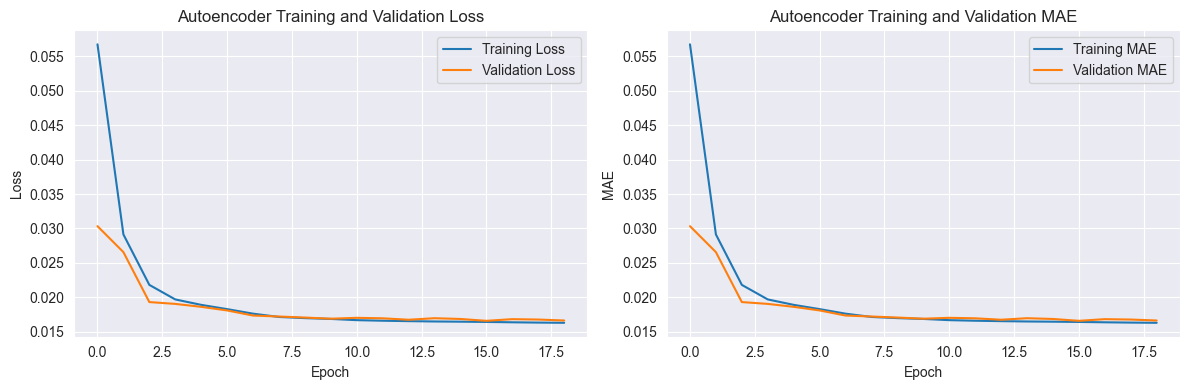


Final Training Loss: 0.0163
Final Validation Loss: 0.0166


In [11]:
# Early stopping callback
early_stopping_ae = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the autoencoder
print("Training Autoencoder...")
history_ae = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stopping_ae],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_ae.history['loss'], label='Training Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_ae.history['mae'], label='Training MAE')
plt.plot(history_ae.history['val_mae'], label='Validation MAE')
plt.title('Autoencoder Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final training and validation loss
final_train_loss = history_ae.history['loss'][-1]
final_val_loss = history_ae.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

## 8. Extract Encoded Features

Extracting encoded features...
Original feature dimension: 70
Encoded feature dimension: 32
Dimensionality reduction: 54.29%

Visualizing encoded features using PCA...


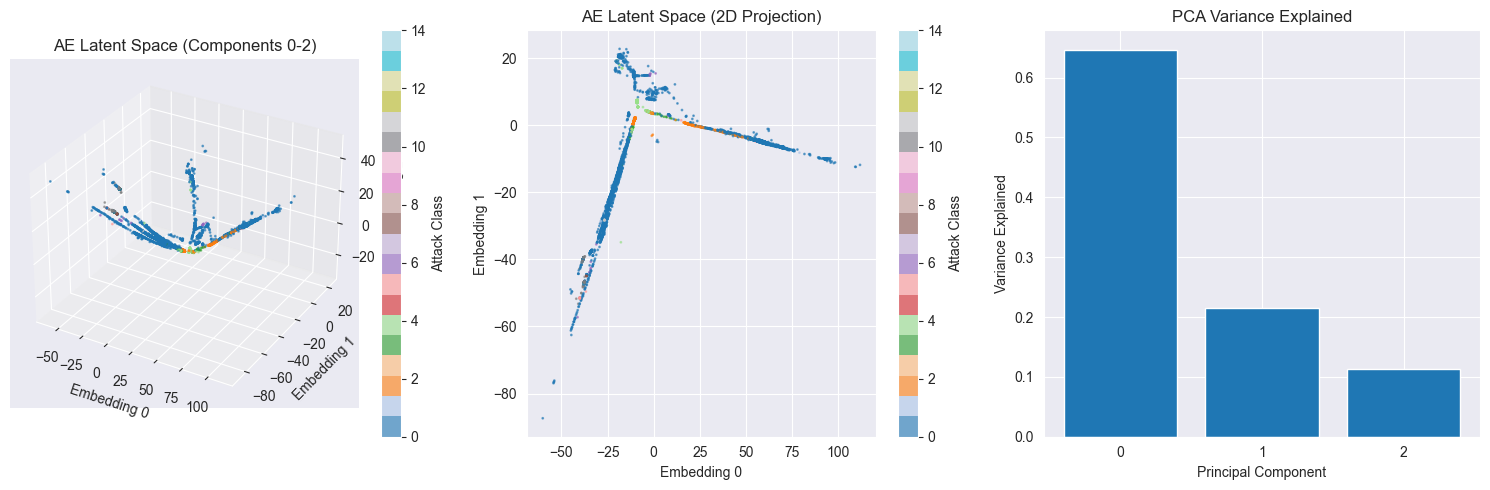


Cumulative variance explained by 3 components: 0.9744


In [12]:
# Extract encoded features using the trained encoder
print("Extracting encoded features...")
X_train_encoded = encoder.predict(X_train, batch_size=1024, verbose=0)
X_test_encoded = encoder.predict(X_test, batch_size=1024, verbose=0)

print(f"Original feature dimension: {X_train.shape[1]}")
print(f"Encoded feature dimension: {X_train_encoded.shape[1]}")
print(f"Dimensionality reduction: {(1 - X_train_encoded.shape[1]/X_train.shape[1])*100:.2f}%")

# Visualize encoded features using PCA for comparison
print("\nVisualizing encoded features using PCA...")

# Sample data for visualization (use subset for faster computation)
sample_size = min(10000, len(X_train_encoded))
sample_indices = np.random.choice(len(X_train_encoded), sample_size, replace=False)

X_sample_encoded = X_train_encoded[sample_indices]
y_sample = y_train[sample_indices]

# Apply PCA for 3D visualization
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_sample_encoded)

# 3D scatter plot
fig = plt.figure(figsize=(15, 5))

# Plot 1: First 3 components
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                       c=y_sample, cmap='tab20', s=1, alpha=0.6)
ax1.set_xlabel('Embedding 0')
ax1.set_ylabel('Embedding 1')
ax1.set_zlabel('Embedding 2')
ax1.set_title('AE Latent Space (Components 0-2)')
plt.colorbar(scatter1, ax=ax1, label='Attack Class')

# Plot 2: 2D projection
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], 
                       c=y_sample, cmap='tab20', s=1, alpha=0.6)
ax2.set_xlabel('Embedding 0')
ax2.set_ylabel('Embedding 1')
ax2.set_title('AE Latent Space (2D Projection)')
plt.colorbar(scatter2, ax=ax2, label='Attack Class')

# Plot 3: Feature importance (variance explained)
ax3 = fig.add_subplot(133)
ax3.bar(range(3), pca_3d.explained_variance_ratio_)
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Variance Explained')
ax3.set_title('PCA Variance Explained')
ax3.set_xticks(range(3))

plt.tight_layout()
plt.show()

print(f"\nCumulative variance explained by 3 components: {pca_3d.explained_variance_ratio_.sum():.4f}")

## 9. CNN Inception with Attention Mechanism (CIAM)

Following the paper's architecture:
- Input: 32 encoded features
- Conv1D layer (16 filters)
- Inception module with 3 parallel branches
- Attention mechanism
- MaxPooling1D
- Flatten
- 3 Dense layers (16, 8, 8 units)
- Dropout (0.1)
- Output layer (softmax)
- Total parameters: 15,624

In [14]:
def build_cnn_inception_attention(input_shape, n_classes):
    """
    Build CNN Inception with Attention Mechanism (CIAM) as per the paper
    
    Args:
        input_shape: Shape of input features (encoding_dim, 1)
        n_classes: Number of output classes
    
    Returns:
        model: CIAM model
    """
    # Input layer
    input_layer = Input(shape=input_shape, name='input')
    
    # Initial Conv1D layer
    x = Conv1D(filters=16, kernel_size=1, padding='same', activation='relu', 
               name='conv1d_initial')(input_layer)
    
    # Inception Module - 3 parallel branches
    # Branch 1: 1x1 convolution
    branch1 = Conv1D(filters=16, kernel_size=1, padding='same', activation='relu', 
                     name='inception_branch1')(x)
    
    # Branch 2: 3x3 convolution
    branch2 = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', 
                     name='inception_branch2')(x)
    
    # Branch 3: MaxPooling + 1x1 convolution
    branch3 = MaxPooling1D(pool_size=3, strides=1, padding='same', 
                           name='inception_branch3_pool')(x)
    branch3 = Conv1D(filters=16, kernel_size=1, padding='same', activation='relu', 
                     name='inception_branch3_conv')(branch3)
    
    # Concatenate all branches
    inception_output = Concatenate(name='inception_concat')([branch1, branch2, branch3])
    
    # Attention Mechanism
    # Global Average Pooling to get feature importance
    attention_pool = GlobalAveragePooling1D(name='attention_pool')(inception_output)
    
    # Attention weights through dense layers
    attention = Dense(1, activation='sigmoid', name='attention_dense')(attention_pool)
    attention = Reshape((1, 1), name='attention_reshape')(attention)
    
    # Apply attention weights to inception output
    attended = Multiply(name='attention_multiply')([inception_output, attention])
    
    # MaxPooling
    pooled = MaxPooling1D(pool_size=2, name='max_pool')(attended)
    
    # Flatten
    flattened = Flatten(name='flatten')(pooled)
    
    # Fully Connected Layers
    dense1 = Dense(16, activation='relu', name='dense1')(flattened)
    dropout1 = Dropout(0.1, name='dropout1')(dense1)
    
    dense2 = Dense(8, activation='relu', name='dense2')(dropout1)
    dropout2 = Dropout(0.1, name='dropout2')(dense2)
    
    dense3 = Dense(8, activation='relu', name='dense3')(dropout2)
    dropout3 = Dropout(0.1, name='dropout3')(dense3)
    
    # Output layer
    output = Dense(n_classes, activation='softmax', name='output')(dropout3)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output, name='CIAM')
    
    return model

# Reshape encoded features for Conv1D input (samples, timesteps, features)
X_train_reshaped = X_train_encoded.reshape(X_train_encoded.shape[0], X_train_encoded.shape[1], 1)
X_test_reshaped = X_test_encoded.reshape(X_test_encoded.shape[0], X_test_encoded.shape[1], 1)

print(f"Reshaped training data: {X_train_reshaped.shape}")
print(f"Reshaped test data: {X_test_reshaped.shape}")

# Convert labels to categorical for multiclass classification
y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_test_categorical = to_categorical(y_test, num_classes=n_classes)

# Build the CIAM model
input_shape = (encoding_dim, 1)
ciam_model = build_cnn_inception_attention(input_shape, n_classes)

# Compile the model
ciam_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

print("\nCIAM Model Architecture:")
ciam_model.summary()

# Count trainable parameters
trainable_params = ciam_model.count_params()
print(f"\nTotal trainable parameters: {trainable_params:,}")
print(f"Target parameters (from paper): 15,624")

Reshaped training data: (2017890, 32, 1)
Reshaped test data: (504473, 32, 1)

CIAM Model Architecture:


Model: "CIAM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 32, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_initial      │ (None, 32, 16)    │         32 │ input[0][0]       │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_branch3_… │ (None, 32, 16)    │          0 │ conv1d_initial[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_branch1   │ (None, 32, 16)    │        272 │ conv1d_initial[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_branch2   │ (None, 32, 16)    │        784 │ conv1d_initial[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_branch3_… │ (None, 32, 16)    │        272 │ inception_branch… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_concat    │ (None, 32, 48)    │          0 │ inception_branch… │
│ (Concatenate)       │                   │            │ inception_branch… │
│                     │                   │            │ inception_branch… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_pool      │ (None, 48)        │          0 │ inception_concat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 1)         │         49 │ attention_pool[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_reshape   │ (None, 1, 1)      │          0 │ attention_dense[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_multiply  │ (None, 32, 48)    │          0 │ inception_concat… │
│ (Multiply)          │                   │            │ attention_reshap… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool            │ (None, 16, 48)    │          0 │ attention_multip… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ max_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 16)        │     12,304 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 16)        │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 8)         │        136 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 8)         │          0 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3 (Dense)      │ (None, 8)         │         72 │ dropout2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout3 (Dropout)  │ (None, 8)         │          0 │ dense3[0][0]    

 Total params: 14,056 (54.91 KB)

 Trainable params: 14,056 (54.91 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 14,056
Target parameters (from paper): 15,624


## 10. Train the CIAM Model

Training CIAM Model...
Epoch 1/150
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - Precision: 0.7022 - Recall: 0.2574 - accuracy: 0.3754 - loss: 1.8611 - val_Precision: 0.9164 - val_Recall: 0.8940 - val_accuracy: 0.9113 - val_loss: 0.3778 - learning_rate: 1.0000e-04
Epoch 2/150
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - Precision: 0.9216 - Recall: 0.8479 - accuracy: 0.8948 - loss: 0.4595 - val_Precision: 0.9290 - val_Recall: 0.9239 - val_accuracy: 0.9257 - val_loss: 0.2734 - learning_rate: 1.0000e-04
Epoch 3/150
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - Precision: 0.9346 - Recall: 0.8783 - accuracy: 0.9091 - loss: 0.3482 - val_Precision: 0.9509 - val_Recall: 0.9172 - val_accuracy: 0.9269 - val_loss: 0.2351 - learning_rate: 1.0000e-04
Epoch 4/150
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - Precision: 0.9400 - Recall: 0.8879 - accuracy: 0.9152 - loss: 0.2992 - val_Precision: 0.9523 - val_Recall: 0.9182 - val_accuracy: 0.9279 - val_loss: 0.2144 - learning_rate: 1.0000e-04
Epoch 5/150


KeyError: 'precision'

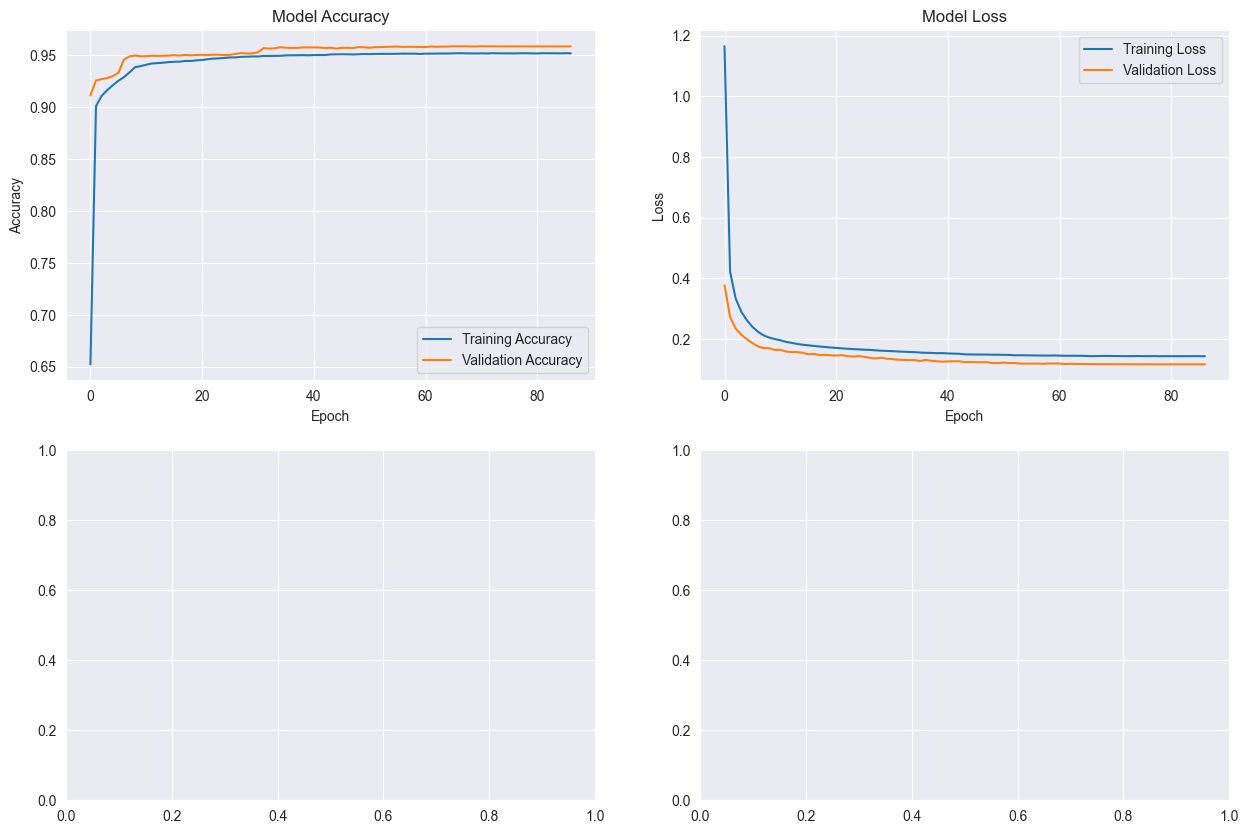

In [15]:
# Callbacks
early_stopping_ciam = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("Training CIAM Model...")
start_time = time.time()

history_ciam = ciam_model.fit(
    X_train_reshaped, y_train_categorical,
    epochs=150,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stopping_ciam, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history_ciam.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history_ciam.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history_ciam.history['loss'], label='Training Loss')
axes[0, 1].plot(history_ciam.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history_ciam.history['precision'], label='Training Precision')
axes[1, 0].plot(history_ciam.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history_ciam.history['recall'], label='Training Recall')
axes[1, 1].plot(history_ciam.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"Accuracy: {history_ciam.history['accuracy'][-1]:.4f}")
print(f"Loss: {history_ciam.history['loss'][-1]:.4f}")
print(f"Precision: {history_ciam.history['precision'][-1]:.4f}")
print(f"Recall: {history_ciam.history['recall'][-1]:.4f}")

print("\nFinal Validation Metrics:")
print(f"Accuracy: {history_ciam.history['val_accuracy'][-1]:.4f}")
print(f"Loss: {history_ciam.history['val_loss'][-1]:.4f}")
print(f"Precision: {history_ciam.history['val_precision'][-1]:.4f}")
print(f"Recall: {history_ciam.history['val_recall'][-1]:.4f}")

## 11. Model Evaluation on Test Set

In [16]:
# Evaluate on test set
print("Evaluating on test set...")

# Measure inference time
start_time = time.time()
y_pred_proba = ciam_model.predict(X_test_reshaped, batch_size=1024, verbose=0)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
test_loss, test_accuracy, test_precision, test_recall = ciam_model.evaluate(
    X_test_reshaped, y_test_categorical, verbose=0
)

# Additional metrics
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Inference time per sample
avg_inference_time = inference_time / len(X_test)

print("\n" + "="*60)
print("TEST SET PERFORMANCE METRICS (Multiclass)")
print("="*60)
print(f"Accuracy:                {test_accuracy*100:.2f}%")
print(f"Precision:               {test_precision*100:.2f}%")
print(f"Recall:                  {test_recall*100:.2f}%")
print(f"F1-Score:                {f1*100:.2f}%")
print(f"Matthews Correlation:    {mcc:.4f}")
print(f"Test Loss:               {test_loss:.4f}")
print(f"Total Inference Time:    {inference_time:.4f} seconds")
print(f"Avg Inference per Sample: {avg_inference_time:.6f} seconds")
print(f"Samples per Second:      {1/avg_inference_time:.2f}")
print("="*60)

# Compare with paper results
print("\nComparison with Paper Results:")
print(f"Paper Accuracy (Multiclass):    99.44%")
print(f"Our Accuracy (Multiclass):      {test_accuracy*100:.2f}%")
print(f"\nPaper Inference Time:           0.000411 s/sample")
print(f"Our Inference Time:             {avg_inference_time:.6f} s/sample")

Evaluating on test set...

TEST SET PERFORMANCE METRICS (Multiclass)
Accuracy:                95.86%
Precision:               96.10%
Recall:                  95.76%
F1-Score:                95.36%
Matthews Correlation:    0.8620
Test Loss:               0.1157
Total Inference Time:    0.8925 seconds
Avg Inference per Sample: 0.000002 seconds
Samples per Second:      565212.95

Comparison with Paper Results:
Paper Accuracy (Multiclass):    99.44%
Our Accuracy (Multiclass):      95.86%

Paper Inference Time:           0.000411 s/sample
Our Inference Time:             0.000002 s/sample


## 12. Detailed Classification Report

In [17]:
# Classification report
print("\nDetailed Classification Report:")
print("="*80)
report = classification_report(
    y_test, y_pred, 
    target_names=label_encoder.classes_,
    digits=4
)
print(report)

# Per-class accuracy
print("\nPer-Class Accuracy:")
print("="*80)
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test == i
    if class_mask.sum() > 0:
        class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
        print(f"{class_name:30s}: {class_acc*100:6.2f}% ({class_mask.sum():6d} samples)")


Detailed Classification Report:
                            precision    recall  f1-score   support

                    BENIGN     0.9776    0.9790    0.9783    419297
                       Bot     0.0000    0.0000    0.0000       391
                      DDoS     0.9709    0.9385    0.9544     25603
             DoS GoldenEye     0.7929    0.0540    0.1010      2057
                  DoS Hulk     0.9362    0.8954    0.9153     34570
          DoS Slowhttptest     0.0000    0.0000    0.0000      1046
             DoS slowloris     0.0000    0.0000    0.0000      1077
               FTP-Patator     0.0000    0.0000    0.0000      1187
                Heartbleed     0.0000    0.0000    0.0000         2
              Infiltration     0.0000    0.0000    0.0000         7
                  PortScan     0.6757    0.9889    0.8028     18164
               SSH-Patator     0.0000    0.0000    0.0000       644
  Web Attack � Brute Force     0.0000    0.0000    0.0000       294
Web Attack � S

## 13. Confusion Matrix

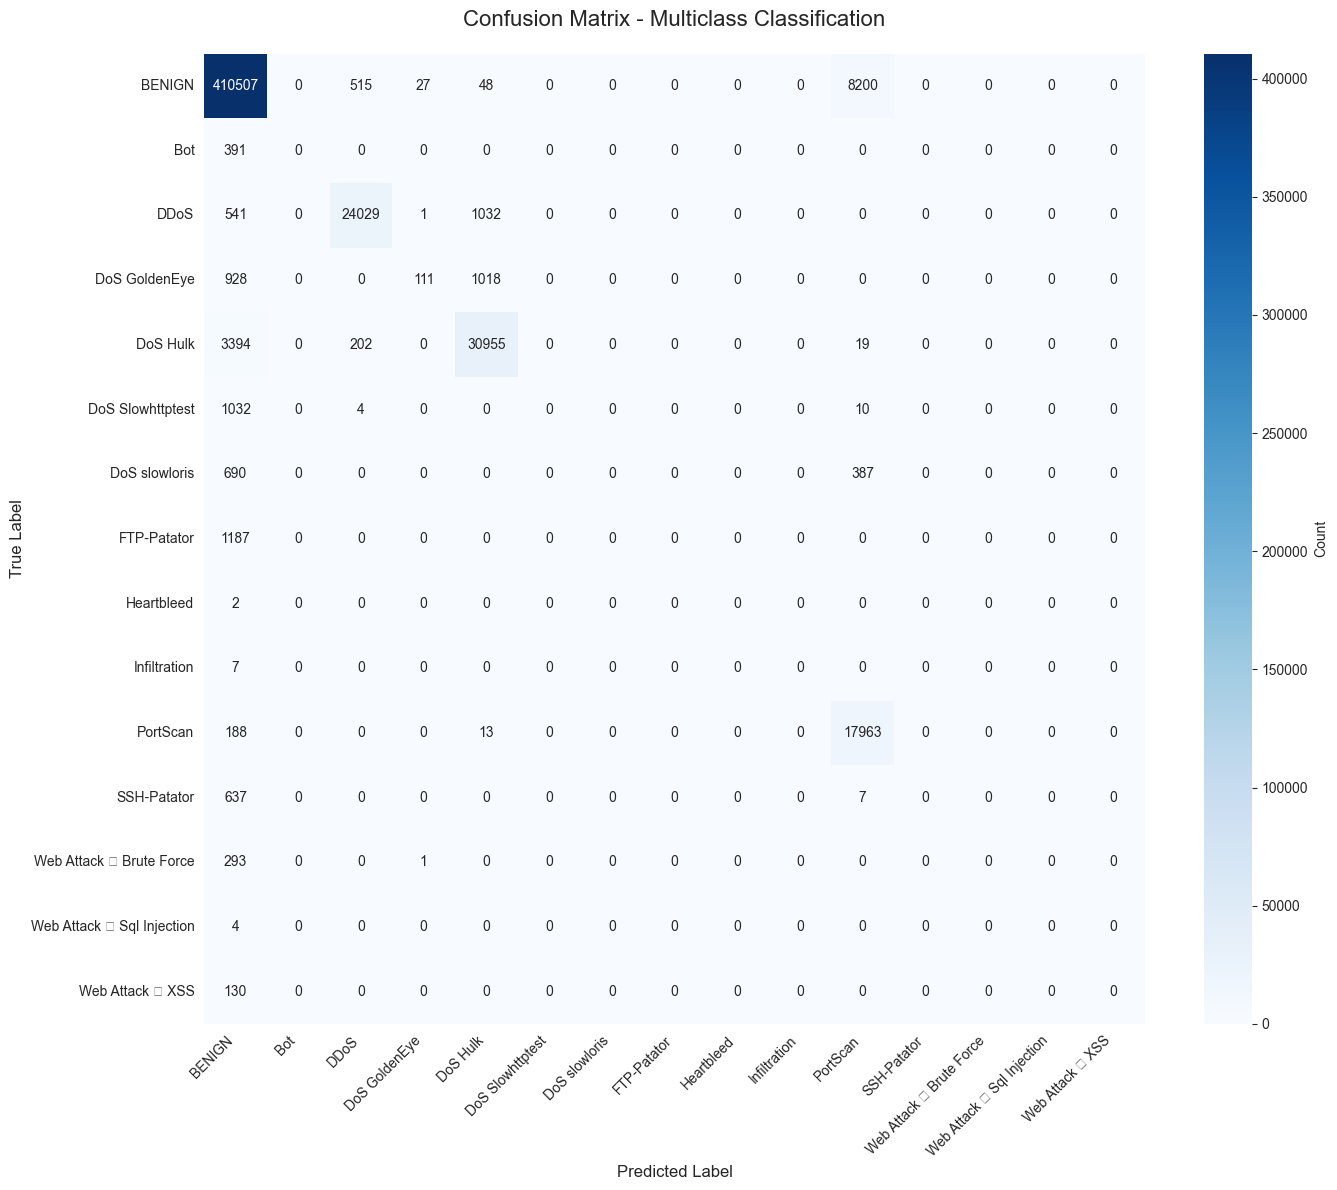

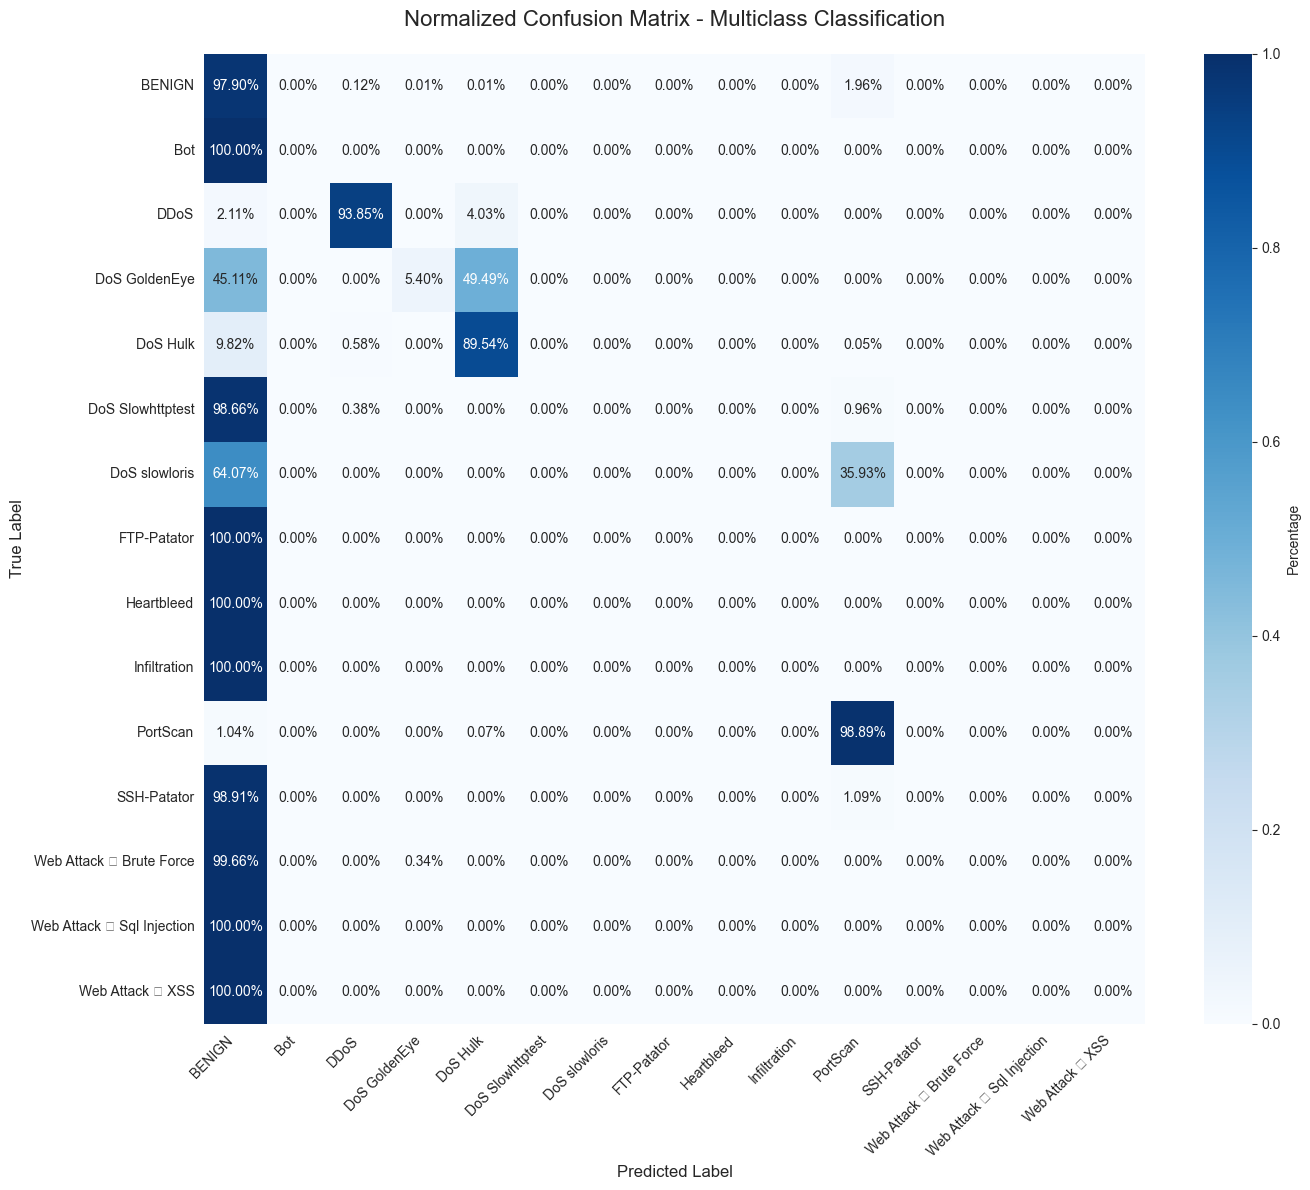

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Multiclass Classification', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Multiclass Classification', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 14. ROC Curve and AUC Score

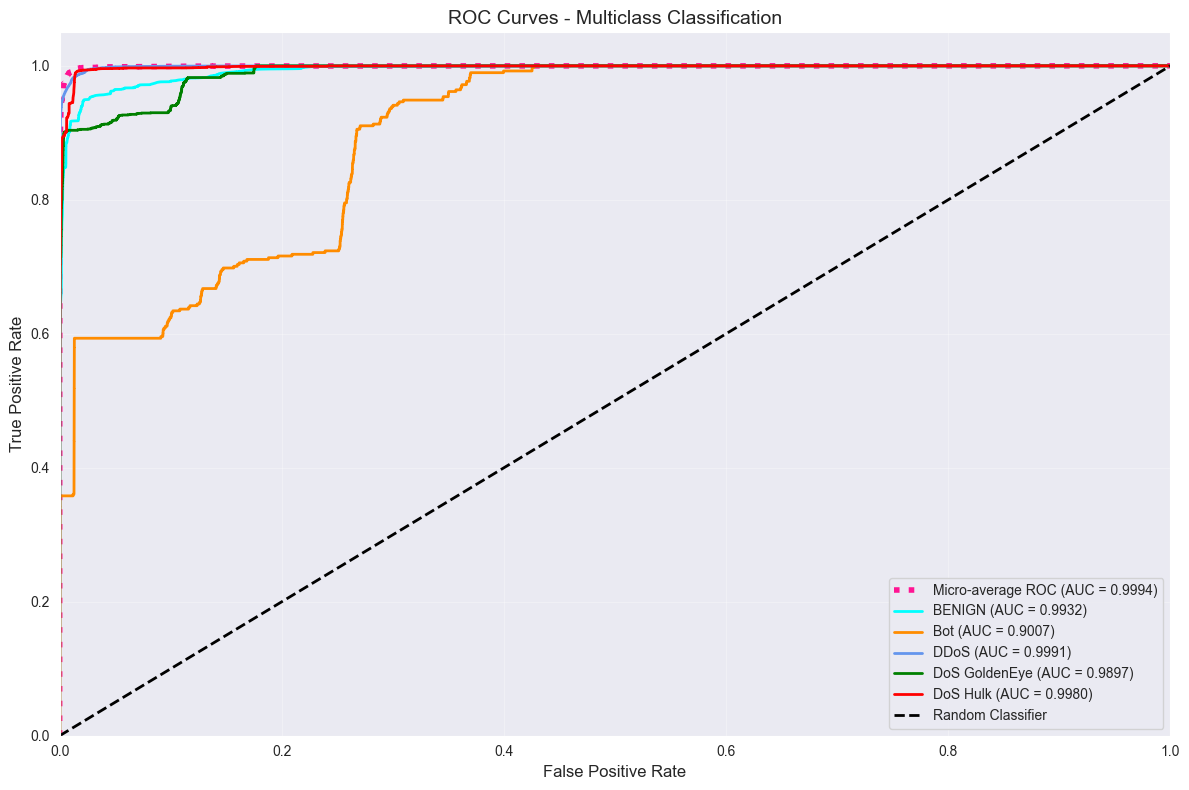


AUC Scores per Class:
BENIGN                        : 0.9932
Bot                           : 0.9007
DDoS                          : 0.9991
DoS GoldenEye                 : 0.9897
DoS Hulk                      : 0.9980
DoS Slowhttptest              : 0.9848
DoS slowloris                 : 0.9862
FTP-Patator                   : 0.9937
Heartbleed                    : 0.7273
Infiltration                  : 0.6058
PortScan                      : 0.9962
SSH-Patator                   : 0.9874
Web Attack � Brute Force      : 0.9674
Web Attack � Sql Injection    : 0.8402
Web Attack � XSS              : 0.9863

Micro-average AUC: 0.9994


In [19]:
# ROC Curve for multiclass
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(12, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curves for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 
                'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
                'magenta', 'yellow', 'black', 'lime'])

for i, color in zip(range(min(n_classes, 5)), colors):  # Plot first 5 classes for clarity
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multiclass Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores for all classes
print("\nAUC Scores per Class:")
print("="*60)
for i in range(n_classes):
    print(f"{label_encoder.classes_[i]:30s}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

## 15. Binary Classification (Normal vs Attack)

Following the paper's binary classification experiment

In [20]:
# Create binary labels (0: Benign, 1: Attack)
# Assuming 'BENIGN' is class 0 after label encoding
y_binary = (y_encoded != 0).astype(int)

# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_normalized, y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print("Binary Classification Setup:")
print(f"Training set: {X_train_bin.shape}")
print(f"Test set: {X_test_bin.shape}")
print(f"\nClass distribution in training:")
unique, counts = np.unique(y_train_bin, return_counts=True)
for label, count in zip(['Benign', 'Attack'], counts):
    print(f"{label}: {count} ({count/len(y_train_bin)*100:.2f}%)")

# Extract encoded features for binary classification
X_train_bin_encoded = encoder.predict(X_train_bin, batch_size=1024, verbose=0)
X_test_bin_encoded = encoder.predict(X_test_bin, batch_size=1024, verbose=0)

# Reshape for Conv1D
X_train_bin_reshaped = X_train_bin_encoded.reshape(X_train_bin_encoded.shape[0], encoding_dim, 1)
X_test_bin_reshaped = X_test_bin_encoded.reshape(X_test_bin_encoded.shape[0], encoding_dim, 1)

# Convert to categorical
y_train_bin_cat = to_categorical(y_train_bin, num_classes=2)
y_test_bin_cat = to_categorical(y_test_bin, num_classes=2)

# Build binary CIAM model
ciam_binary = build_cnn_inception_attention(input_shape, n_classes=2)

ciam_binary.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

print("\nTraining Binary Classification Model...")

# Callbacks
early_stopping_bin = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train
start_time = time.time()
history_binary = ciam_binary.fit(
    X_train_bin_reshaped, y_train_bin_cat,
    epochs=150,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stopping_bin],
    verbose=1
)
binary_training_time = time.time() - start_time

print(f"\nBinary training completed in {binary_training_time:.2f} seconds")

Binary Classification Setup:
Training set: (2017890, 70)
Test set: (504473, 70)

Class distribution in training:
Benign: 1677188 (83.12%)
Attack: 340702 (16.88%)

Training Binary Classification Model...
Epoch 1/150
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - Precision: 0.8529 - Recall: 0.8528 - accuracy: 0.8529 - loss: 0.3957 - val_Precision: 0.9500 - val_Recall: 0.9500 - val_accuracy: 0.9500 - val_loss: 0.1286
Epoch 2/150
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - Precision: 0.9409 - Recall: 0.9409 - accuracy: 0.9409 - loss: 0.1591 - val_Precision: 0.9525 - val_Recall: 0.9525 - val_accuracy: 0.9525 - val_loss: 0.1107
Epoch 3/150
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - Precision: 0.9463 - Recall: 0.9463 - accuracy: 0.9463 - loss: 0.1287 - val_Precision: 0.9562 - val_Recall: 0.9562 - val_accuracy: 0.9562 - val_loss: 0.1021
Epoch 4/150
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - Precision: 0.9517 - Recall: 0.9517 - accuracy: 0.9517 - loss: 0.1147 - val_Precision: 0.9598 - val_

## 16. Binary Classification Evaluation

Evaluating Binary Classification Model...

TEST SET PERFORMANCE METRICS (Binary)
Accuracy:                96.94%
Precision:               96.94%
Recall:                  96.94%
F1-Score:                96.96%
Matthews Correlation:    0.8930
Test Loss:               0.0672
Avg Inference per Sample: 0.000002 seconds

Comparison with Paper Results:
Paper Accuracy (Binary):        99.99%
Our Accuracy (Binary):          96.94%

Paper Inference Time (Binary):  0.000209 s/sample
Our Inference Time (Binary):    0.000002 s/sample

Binary Classification Report:
              precision    recall  f1-score   support

      Benign     0.9859    0.9771    0.9815    419297
      Attack     0.8919    0.9314    0.9112     85176

    accuracy                         0.9694    504473
   macro avg     0.9389    0.9542    0.9463    504473
weighted avg     0.9701    0.9694    0.9696    504473



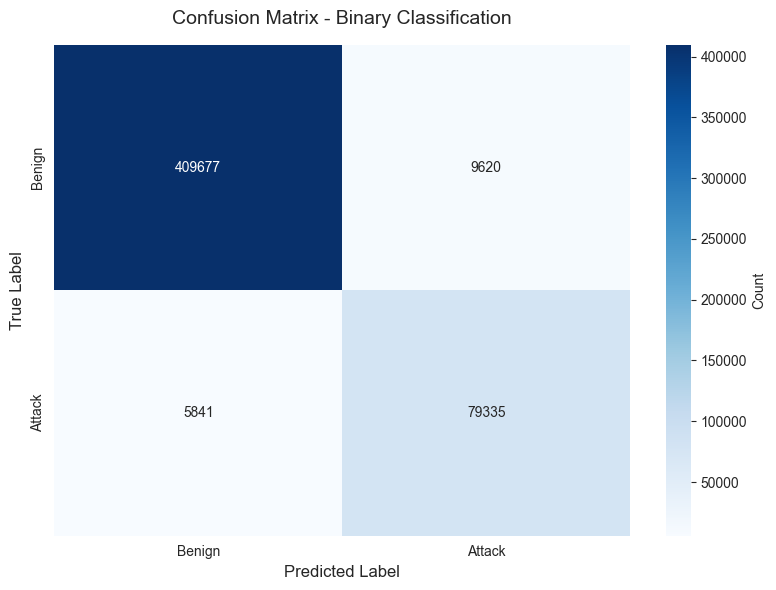

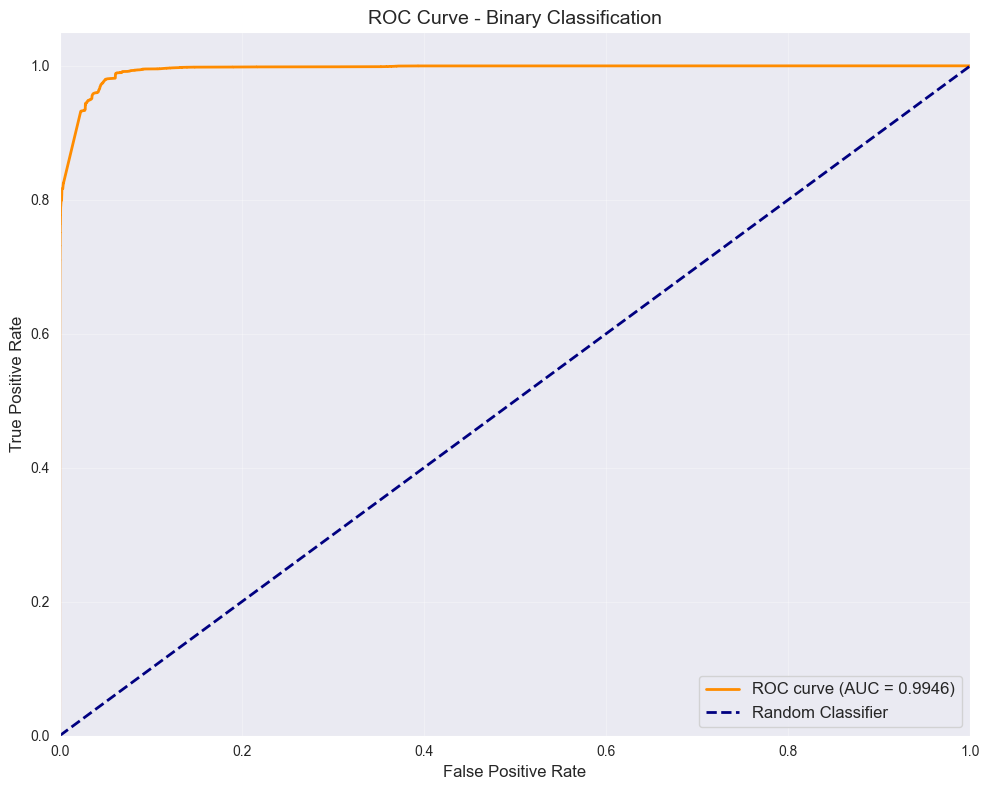


Binary Classification AUC: 0.9946


In [21]:
# Evaluate binary model
print("Evaluating Binary Classification Model...")

# Measure inference time
start_time = time.time()
y_pred_bin_proba = ciam_binary.predict(X_test_bin_reshaped, batch_size=1024, verbose=0)
binary_inference_time = time.time() - start_time

y_pred_bin = np.argmax(y_pred_bin_proba, axis=1)

# Calculate metrics
bin_loss, bin_accuracy, bin_precision, bin_recall = ciam_binary.evaluate(
    X_test_bin_reshaped, y_test_bin_cat, verbose=0
)

bin_f1 = f1_score(y_test_bin, y_pred_bin, average='weighted')
bin_mcc = matthews_corrcoef(y_test_bin, y_pred_bin)
avg_bin_inference = binary_inference_time / len(X_test_bin)

print("\n" + "="*60)
print("TEST SET PERFORMANCE METRICS (Binary)")
print("="*60)
print(f"Accuracy:                {bin_accuracy*100:.2f}%")
print(f"Precision:               {bin_precision*100:.2f}%")
print(f"Recall:                  {bin_recall*100:.2f}%")
print(f"F1-Score:                {bin_f1*100:.2f}%")
print(f"Matthews Correlation:    {bin_mcc:.4f}")
print(f"Test Loss:               {bin_loss:.4f}")
print(f"Avg Inference per Sample: {avg_bin_inference:.6f} seconds")
print("="*60)

print("\nComparison with Paper Results:")
print(f"Paper Accuracy (Binary):        99.99%")
print(f"Our Accuracy (Binary):          {bin_accuracy*100:.2f}%")
print(f"\nPaper Inference Time (Binary):  0.000209 s/sample")
print(f"Our Inference Time (Binary):    {avg_bin_inference:.6f} s/sample")

# Classification report
print("\n" + "="*60)
print("Binary Classification Report:")
print("="*60)
print(classification_report(y_test_bin, y_pred_bin, 
                          target_names=['Benign', 'Attack'],
                          digits=4))

# Confusion matrix
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Binary Classification', fontsize=14, pad=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# ROC Curve for binary classification
fpr_bin, tpr_bin, _ = roc_curve(y_test_bin, y_pred_bin_proba[:, 1])
roc_auc_bin = auc(fpr_bin, tpr_bin)

plt.figure(figsize=(10, 8))
plt.plot(fpr_bin, tpr_bin, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_bin:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Binary Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBinary Classification AUC: {roc_auc_bin:.4f}")

## 17. Model Summary and Comparison Table

In [22]:
# Create comparison table
results_comparison = pd.DataFrame({
    'Metric': ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score (%)', 
               'MCC', 'Test Loss', 'Inference Time (s/sample)'],
    'Paper (Multi)': [99.44, 99.08, 99.44, 99.26, 0.9872, 0.0197, 0.000411],
    'Our Model (Multi)': [
        round(test_accuracy*100, 2),
        round(test_precision*100, 2),
        round(test_recall*100, 2),
        round(f1*100, 2),
        round(mcc, 4),
        round(test_loss, 4),
        round(avg_inference_time, 6)
    ],
    'Paper (Binary)': [99.99, 99.99, 99.99, 99.99, '-', 0.0246, 0.000209],
    'Our Model (Binary)': [
        round(bin_accuracy*100, 2),
        round(bin_precision*100, 2),
        round(bin_recall*100, 2),
        round(bin_f1*100, 2),
        round(bin_mcc, 4),
        round(bin_loss, 4),
        round(avg_bin_inference, 6)
    ]
})

print("\n" + "="*80)
print("PERFORMANCE COMPARISON: PAPER vs OUR IMPLEMENTATION")
print("="*80)
print(results_comparison.to_string(index=False))
print("="*80)


PERFORMANCE COMPARISON: PAPER vs OUR IMPLEMENTATION
                   Metric  Paper (Multi)  Our Model (Multi) Paper (Binary)  Our Model (Binary)
             Accuracy (%)      99.440000          95.860000          99.99           96.940000
            Precision (%)      99.080000          96.100000          99.99           96.940000
               Recall (%)      99.440000          95.760000          99.99           96.940000
             F1-Score (%)      99.260000          95.360000          99.99           96.960000
                      MCC       0.987200           0.862000              -            0.893000
                Test Loss       0.019700           0.115700         0.0246            0.067200
Inference Time (s/sample)       0.000411           0.000002       0.000209            0.000002


## 18. Save Models and Results

In [23]:
# Create directory for saving models
import os
save_dir = 'ae_ciam_models'
os.makedirs(save_dir, exist_ok=True)

# Save models
print("Saving models...")
autoencoder.save(os.path.join(save_dir, 'autoencoder_model.h5'))
encoder.save(os.path.join(save_dir, 'encoder_model.h5'))
ciam_model.save(os.path.join(save_dir, 'ciam_multiclass_model.h5'))
ciam_binary.save(os.path.join(save_dir, 'ciam_binary_model.h5'))

# Save scaler and label encoder
import joblib
joblib.dump(scaler, os.path.join(save_dir, 'minmax_scaler.pkl'))
joblib.dump(label_encoder, os.path.join(save_dir, 'label_encoder.pkl'))

# Save results
results_comparison.to_csv(os.path.join(save_dir, 'results_comparison.csv'), index=False)

# Save training history
history_df_ae = pd.DataFrame(history_ae.history)
history_df_ciam = pd.DataFrame(history_ciam.history)
history_df_binary = pd.DataFrame(history_binary.history)

history_df_ae.to_csv(os.path.join(save_dir, 'autoencoder_history.csv'), index=False)
history_df_ciam.to_csv(os.path.join(save_dir, 'ciam_multiclass_history.csv'), index=False)
history_df_binary.to_csv(os.path.join(save_dir, 'ciam_binary_history.csv'), index=False)

print(f"\nAll models and results saved to '{save_dir}' directory")
print("\nSaved files:")
for file in os.listdir(save_dir):
    print(f"  - {file}")

Saving models...

All models and results saved to 'ae_ciam_models' directory

Saved files:
  - label_encoder.pkl
  - results_comparison.csv
  - ciam_binary_history.csv
  - autoencoder_history.csv
  - encoder_model.h5
  - ciam_binary_model.h5
  - ciam_multiclass_model.h5
  - ciam_multiclass_history.csv
  - minmax_scaler.pkl
  - autoencoder_model.h5


## 19. Model Architecture Visualization

In [24]:
# Visualize model architectures
from tensorflow.keras.utils import plot_model

# Plot autoencoder
plot_model(autoencoder, to_file=os.path.join(save_dir, 'autoencoder_architecture.png'),
           show_shapes=True, show_layer_names=True, rankdir='TB', dpi=96)

# Plot CIAM model
plot_model(ciam_model, to_file=os.path.join(save_dir, 'ciam_architecture.png'),
           show_shapes=True, show_layer_names=True, rankdir='TB', dpi=96)

print("Model architecture diagrams saved!")

You must install pydot (`pip install pydot`) for `plot_model` to work.
You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture diagrams saved!


## 20. Final Summary

In [25]:
print("\n" + "="*80)
print("AE-CIAM IMPLEMENTATION SUMMARY")
print("="*80)
print(f"\nDataset: CICIDS2017")
print(f"Total samples: {len(X_normalized):,}")
print(f"Original features: {input_dim}")
print(f"Encoded features: {encoding_dim}")
print(f"Number of classes: {n_classes}")
print(f"\nAutoencoder:")
print(f"  - Training loss: {final_train_loss:.4f}")
print(f"  - Validation loss: {final_val_loss:.4f}")
print(f"\nCIAM Model (Multiclass):")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Test accuracy: {test_accuracy*100:.2f}%")
print(f"  - Test precision: {test_precision*100:.2f}%")
print(f"  - Test recall: {test_recall*100:.2f}%")
print(f"  - F1-score: {f1*100:.2f}%")
print(f"  - Inference time: {avg_inference_time:.6f} s/sample")
print(f"\nCIAM Model (Binary):")
print(f"  - Test accuracy: {bin_accuracy*100:.2f}%")
print(f"  - Test precision: {bin_precision*100:.2f}%")
print(f"  - Test recall: {bin_recall*100:.2f}%")
print(f"  - F1-score: {bin_f1*100:.2f}%")
print(f"  - Inference time: {avg_bin_inference:.6f} s/sample")
print(f"\nComparison with Paper:")
print(f"  - Paper accuracy (multiclass): 99.44%")
print(f"  - Our accuracy (multiclass): {test_accuracy*100:.2f}%")
print(f"  - Paper accuracy (binary): 99.99%")
print(f"  - Our accuracy (binary): {bin_accuracy*100:.2f}%")
print("\n" + "="*80)
print("Implementation completed successfully!")
print("="*80)


AE-CIAM IMPLEMENTATION SUMMARY

Dataset: CICIDS2017
Total samples: 2,522,363
Original features: 70
Encoded features: 32
Number of classes: 15

Autoencoder:
  - Training loss: 0.0163
  - Validation loss: 0.0166

CIAM Model (Multiclass):
  - Trainable parameters: 14,056
  - Test accuracy: 95.86%
  - Test precision: 96.10%
  - Test recall: 95.76%
  - F1-score: 95.36%
  - Inference time: 0.000002 s/sample

CIAM Model (Binary):
  - Test accuracy: 96.94%
  - Test precision: 96.94%
  - Test recall: 96.94%
  - F1-score: 96.96%
  - Inference time: 0.000002 s/sample

Comparison with Paper:
  - Paper accuracy (multiclass): 99.44%
  - Our accuracy (multiclass): 95.86%
  - Paper accuracy (binary): 99.99%
  - Our accuracy (binary): 96.94%

Implementation completed successfully!
